In [4]:
import os

from langchain_ollama import ChatOllama

from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_chroma import Chroma



In [5]:
def get_llm():

    return ChatOllama(model="llama3.2:3b",temperature = 0)

def get_embeddings():
    return OllamaEmbeddings(model="nomic-embed-text")


In [6]:
CHROMA_PATH = "chroma_db_test_21"

db = Chroma(persist_directory=CHROMA_PATH, embedding_function=get_embeddings())
retriever = db.as_retriever()


In [7]:

from typing_extensions import TypedDict


class AgentState(TypedDict):
    question: str
    grades = list[str] # yes or no answer to document question
    llm_output : str
    documents : list[str] # les reponses
    on_topic : bool # evaluated by the llm

In [8]:
def retrieve_docs(state: AgentState):
    question = state['question']
    documents = retriever.get_relevant_documents(question)
    print("RETRIEVED DOCUMENTS",documents)
    state['documents']=[doc.page_content for doc in documents]
    return state

In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
import re



class GradeQuestion(BaseModel):
    """Boolean value to check whether a question is releated to the restaurant Bella Vista"""

    score: str = Field(
        description="Question is about restaurant? If yes -> 'yes' if not -> 'no'"
    )


def question_classifier(state: AgentState):
    question = state["question"]

    # Instructions pour forcer une réponse JSON
    system = """
    You are a grader assessing the topic of a user question.
    The question is: {question}

    You must determine if the question is about Power Studio SCADA or any related topics.
    The following topics are relevant to Power Studio SCADA:

    1. Information about Power Studio SCADA.
    2. Features and functionalities of Power Studio SCADA.
    3. Integration of Power Studio SCADA with other systems or devices.
    4. Energy management and monitoring using Power Studio SCADA.
    5. Troubleshooting or support for Power Studio SCADA.

    If the question mentions Power Studio SCADA in any way, or if it refers to one of the topics listed above,
    return the score as 'yes'.

    If it does not relate to Power Studio SCADA or these topics, return the score as 'no'.

    Provide the answer in this exact JSON format:

    {{ "score": "<response>" }}
"""




    # Création du prompt avec instructions
    prompt = PromptTemplate(template=system, input_variables=["question","format_instructions"])
    model = get_llm()
    parser = PydanticOutputParser(pydantic_object=GradeQuestion)

    structured_llm = model.with_structured_output(GradeQuestion)
    grader_llm = prompt | model

    # Invocation du modèle avec la question de l'utilisateur
    result = grader_llm.invoke({"question": question})
    print("Result from grader_llm:", result.content)
    result=str(result.content)
    try:
        json_regex = r"\{.*?\}"
        match = re.search(json_regex, result)
        json_str = match.group(0)
        print("###########")
        print(json_str)
        print("##########")



        if  "yes" in str(json_str):
            state["on_topic"] = "yes"
        else:
            print("Model output is not in valid JSON format.")
            state["on_topic"] = "Error"
    except Exception as e:
        print(f"Error parsing result: {e}")
        state["on_topic"] = "Error"

    return state


    # Vérification et mise à jour de l'état

    #state["on_topic"] = result.score


    return state

In [10]:
def on_topic_router(state:AgentState):
    on_topic=state["on_topic"]
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

In [11]:
def off_topic_response(state:AgentState):
    state["llm_output"]="I cant respond to that!"
    return state

In [12]:
class GradeDocuments(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'"
    )


def document_grader(state: AgentState):
    docs = state["documents"]
    question = state["question"]

    system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    llm = get_llm()
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm
    scores = []
    for doc in docs:
        result = grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)
    state["grades"] = scores
    return state

In [13]:
def gen_router(state: AgentState):
    grades= state["grades"]
    print("Document Grades",grades)

    if any(grade.lower()=="yes" for grade in grades):
        filtered_grades= [grade for grade in grades if grade.lower()=="yes"]
        print("FILETRED DOCUMENT GRADES:",filtered_grades)
        return "generate"

    else:
        return "rewrite_query"




In [14]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: AgentState):
    question = state["question"]
    system = """You a question re-writer that converts an input question to a better version that is optimized \n
        for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    llm = get_llm()
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    state["question"] = output
    return state

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


def generate_answer(state: AgentState):
    llm = get_llm()
    question = state["question"]
    context = state["documents"]

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(
        template=template,
    )
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})
    state["llm_output"] = result
    return state

In [16]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)

workflow.add_edge("off_topic_response", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router, add
    {
        "on_topic": "retrieve_docs",
        "off_topic": "off_topic_response",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()

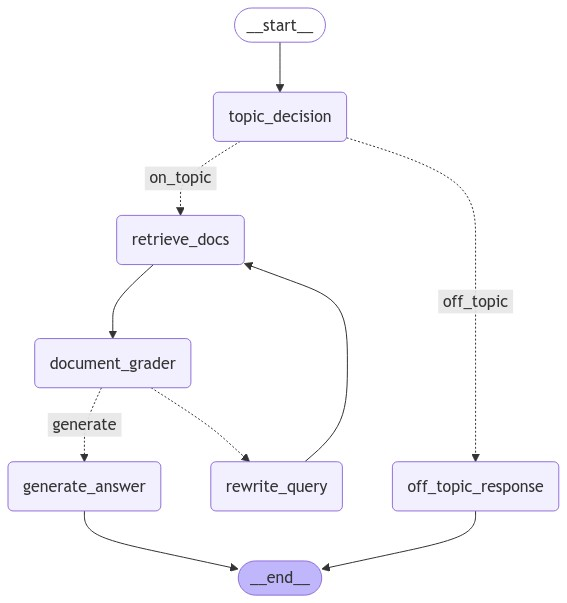

In [17]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [18]:
result = app.invoke({"question": "information about Bella Hadid."})
result["llm_output"]

Result from grader_llm: Since the question is about Bella Hadid and doesn't mention Power Studio SCADA or any related topics, I would return:

{"score": "no"}
###########
{"score": "no"}
##########
Model output is not in valid JSON format.


'I cant respond to that!'

In [21]:
result = app.invoke({"question": "comment utiliser le xml dans power studio scada"})
result["llm_output"]


Result from grader_llm: { "score": "yes" }
###########
{ "score": "yes" }
##########
RETRIEVED DOCUMENTS [Document(metadata={'id': 'D:\\Generative IA\\rag_pdfs\\pdf_data\\M98232001-03-18A.pdf:84:0', 'page': 84, 'source': 'D:\\Generative IA\\rag_pdfs\\pdf_data\\M98232001-03-18A.pdf'}, page_content='PowerStudio      \n         \nInstruc tion Manual    85                                                                                                                       \n1.3.3. SCADA Screens \n \nThe way in which the Scada screens of the HTML5 2.0 client work is almost identical to those of the \nJava or HT ML5 1.0 clients.  \n \nSelect the “ Screens” option from the tools menu to access the Scada screens. The application will \nshow a dialogue box with the available screens that can be selected:  \n \n \nSCADA Screens  \n \nAdditional considerations:  \n \n• The "request interval" parameters and "frames per second" configuration will affect how data is \ndisplayed in these types of scr

'Il n\'y a pas de mention spécifique de l\'utilisation du XML dans le contexte fourni. Cependant, il est possible d\'en déduire quelques informations :\n\n* Le contexte parle de la configuration du serveur Web et des paramètres de mise en œuvre, mais ne mentionne pas explicitement l\'utilisation du XML.\n* Il y a une mention de "variables" qui seront automatiquement mises à jour dans les écrans personnalisés pour la version Scada, ce qui suggère que le XML peut être utilisé pour stocker et gérer ces variables.\n\nEn général, dans Power Studio Scada, l\'XML peut être utilisé pour :\n\n* Stocker et gérer les données de configuration\n* Définir les paramètres de mise en œuvre du serveur Web\n* Gérer les variables qui seront mises à jour automatiquement dans les écrans personnalisés\n\nPour utiliser le XML dans Power Studio Scada, il faudrait consulter la documentation officielle ou rechercher des informations spécifiques sur l\'utilisation de l\'XML dans ce contexte.'

In [20]:
result = app.invoke({"question": "je veux recuperer les donnees depuis power studio scada quelle sont toutes les facons possible pour recuperer les donnnes et l'utilise dans une application externe"})
result["llm_output"]


Result from grader_llm: { "score": "yes" }
###########
{ "score": "yes" }
##########
RETRIEVED DOCUMENTS [Document(metadata={'id': 'D:\\Generative IA\\rag_pdfs\\pdf_data\\M98232201-03-18A.pdf:47:1', 'page': 47, 'source': 'D:\\Generative IA\\rag_pdfs\\pdf_data\\M98232201-03-18A.pdf'}, page_content='The group type for the data to be displayed in the events viewer \ncan be chosen.  \n \n The list may be displayed either complete or not.  \n \n Here the appearance of the control on the SCADA screen is \nspecified. Select ‘button’, ‘image’ or ‘text’.  \n \n6.2.1.7  \n Run control  \n \n Use this tool to incl ude access from the SCADA screen to another application in the system. \nThe properties than can be configured from this control are:  \n \n Specify the complete path to the application that will be called up \nwhen the control entered on the SCADA screen is click ed. For example: \nC:\\WINDOWS \\SYSTEM32 \\CALC.EXE.  \n \n Specify parameters (if needed) to be added to the application c

'Selon le contexte fourni, il semble que Power Studio SCADA propose plusieurs façons de récupérer des données et les utiliser dans une application externe. Voici quelques-unes des méthodes mentionnées :\n\n1. **Utiliser l\'outil "Run control"** : Ce outil permet d\'inclure l\'accès à une autre application dans le système en cliquant sur un contrôle spécifique. Il est possible de spécifier la route complète de l\'application et les paramètres à ajouter pour l\'appeler.\n2. **Utiliser les "Action tools"** : Ces outils permettent de créer des actions qui peuvent être utilisées pour récupérer des données ou exécuter des tâches dans une application externe.\n3. **Utiliser les "Position tools" et les "Page tools"** : Ces outils permettent de positionner et de configurer les contrôles sur la scène SCADA, ce qui peut être utile pour récupérer des données ou exécuter des tâches dans une application externe.\n4. **Utiliser les fonctions mathématiques et temporelles** : Power Studio SCADA propose